## GEOHACKWEEK 2017 <br>ASO vs DHSVM SWE ANALYSIS NOTEBOOK
#### Nicoleta Cristea and Claire Beveridge  <br> UW CEE Hydrology 

In [1]:
# Input local directories
homedir='C:\\Users\\Claire\\Documents\\GitHub\\Geohack\\project\\data'

# NOTE: Please change the file name of your DEM to "dem_90m.tif". 
# At present, the file name needs to be hard-coded into the gdal
# commands for slope and aspect
dem_loc='dem_90m.tif' # DEM raster- SEE NOTE ABOVE!!!!!!!!!
veg_loc='binary_veg_90m.tif' # vegetation raster (binary- 1 for forest, 0 for no forest)
mask_loc='mask90m.tif' # mask of watershed
swe_ASO_loc='ASO_swe_day7.tif' # raster of ASO SWE
swe_model_loc='model_1202_swe_day7.tif' # raster of DHSVM modeled SWE

In [2]:
# Load libraries, import data, create directories
import os
import logging
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from numpy import ma
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.style.use('bmh')

os.chdir(homedir)
dem = gdal.Open(dem_loc)
veg = gdal.Open(veg_loc)
dem_map=dem.ReadAsArray()
veg_map=veg.ReadAsArray()
veg_map[veg_map < 0] = 0

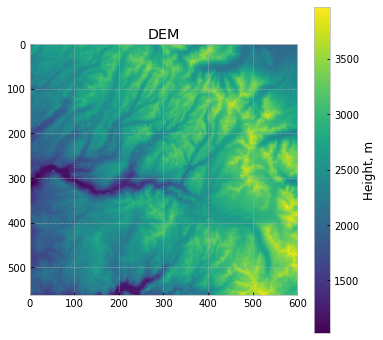

In [3]:
#plot DEM 
plt.figure(figsize = (6,6))
plt.imshow(dem_map)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Height, m')
plt.title('DEM')

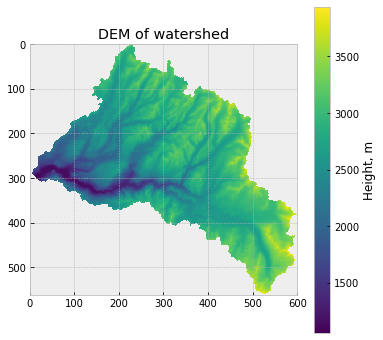

In [4]:
#load basin mask and plot basin DEM
_mask = gdal.Open(mask_loc)
w_mask = _mask.ReadAsArray()
w_dem = ma.masked_where(w_mask == 0, dem_map)
plt.figure(figsize = (6,6))
plt.imshow(w_dem)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Height, m')
plt.title('DEM of watershed')

0...10...20...30...40...50...60...70...80...90...100 - done.


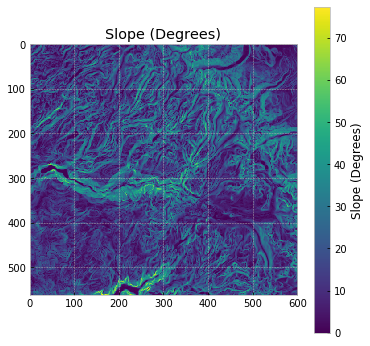

In [5]:
# Generate slope map with gdal and plot
!gdaldem slope dem_90m.tif slope.tif
slope_loc='slope.tif'
slope = gdal.Open(slope_loc)
slope_map=slope.ReadAsArray()

plt.figure(figsize = (6,6))
plt.imshow(slope_map, vmin=0)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Slope (Degrees)')
plt.title('Slope (Degrees)')

0...10...20...30...40...50...60...70...80...90...100 - done.


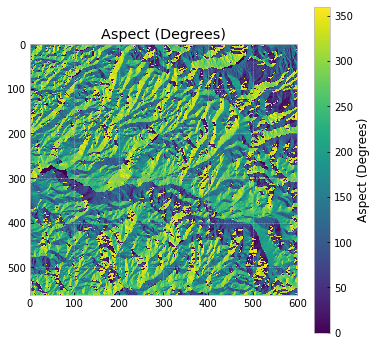

In [6]:
# Generate aspect map with gdal and plot
!gdaldem aspect dem_90m.tif aspect.tif -trigonometric -zero_for_flat 
aspect_loc='aspect.tif'
aspect = gdal.Open(aspect_loc)
aspect_map=aspect.ReadAsArray()

plt.figure(figsize = (6,6))
plt.imshow(aspect_map)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Aspect (Degrees)')
plt.title('Aspect (Degrees)')

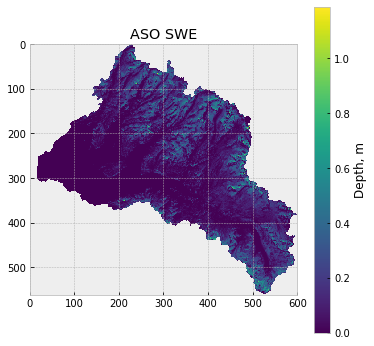

In [7]:
# Import and plot ASO data
swe = gdal.Open(swe_ASO_loc)
swe_map=swe.ReadAsArray()

plt.figure(figsize = (6,6))
plt.imshow(swe_map)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Depth, m')
plt.title('ASO SWE')

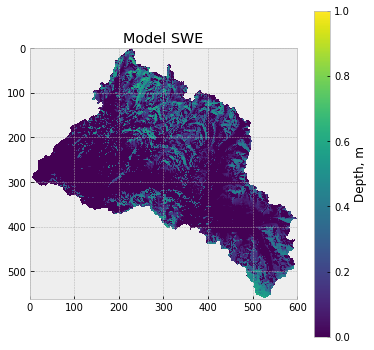

In [8]:
# Import and plot model data
ds_model = gdal.Open(swe_model_loc)
swe_model = ds_model.ReadAsArray()

plt.figure(figsize = (6,6))
plt.imshow(swe_model, vmax=1)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Depth, m')
plt.title('Model SWE')

C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


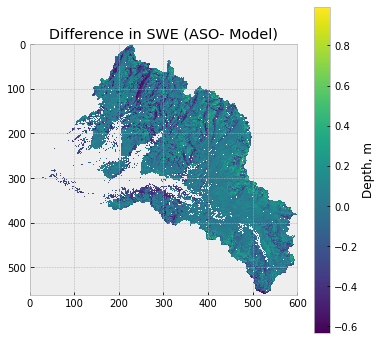

In [9]:
diff = swe_map - swe_model
diff[abs(diff) < 0.001] = np.nan

plt.figure(figsize = (6,6))
plt.imshow(diff)
cbar=plt.colorbar()
cbar.ax.set_ylabel('Depth, m')
plt.title('Difference in SWE (ASO- Model)')

In [10]:
# Define function to reshape raster arrays for computations
def array_resh_pd(array_):
    size_col = array_.shape[0]*array_.shape[1]
    col = np.reshape(array_, size_col)
    a = pd.DataFrame(col)
    return a

In [11]:
# Prep data for 2D Histograms of ASO vs aspect
slp_array=array_resh_pd(slope_map)
asp_array=array_resh_pd(aspect_map)
swe_ASO_array0=array_resh_pd(swe_map)
swe_model_array0=array_resh_pd(swe_model)

values_to_use_ASO=np.where(~np.isnan(swe_ASO_array0))[0]
values_to_use_model=np.where(~np.isnan(swe_model_array0))[0]

swe_ASO_array=np.asarray(swe_ASO_array0.values[values_to_use_ASO])[:,0]
swe_model_array=np.asarray(swe_model_array0.values[values_to_use_model])[:,0]

asp_ASO_array=np.asarray(asp_array.values[values_to_use_ASO])[:,0]
asp_model_array=np.asarray(asp_array.values[values_to_use_model])[:,0]

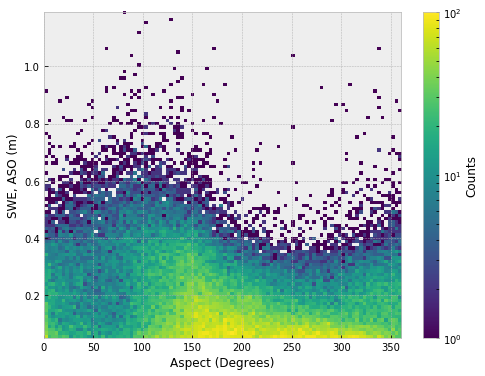

In [12]:
plt.figure(figsize = (8,6))
plt.xlabel('Aspect (Degrees)')
plt.ylabel('SWE, ASO (m)')
plt.hist2d(asp_ASO_array, swe_ASO_array, bins=100, norm=LogNorm(),
           range=[[0, 360], [0.05, np.max(swe_ASO_array)]])
axes = plt.gca()
cbar=plt.colorbar()
cbar.ax.set_ylabel('Counts')

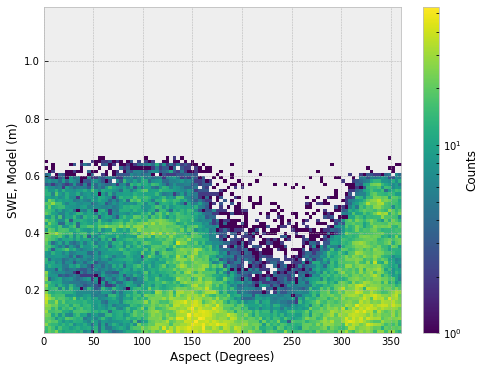

In [13]:
plt.figure(figsize = (8,6))
plt.xlabel('Aspect (Degrees)')
plt.ylabel('SWE, Model (m)')
plt.hist2d(asp_model_array, swe_model_array, bins=100, norm=LogNorm(),
           range=[[0, 360], [0.05, np.max([swe_ASO_array])]])
axes = plt.gca()
cbar=plt.colorbar()
cbar.ax.set_ylabel('Counts')

C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


Number of masked cells= 56400


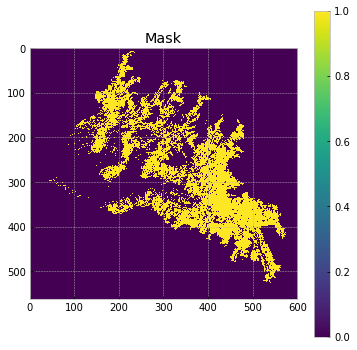

In [14]:
# Define mask function and plot 
def _create_mask(swe_map, dem_map, slope_map, aspect_map,veg_map, swe_range, dem_range, slope_range, aspect_range, veg):
    # swe_map, dem_map, slope_map, veg_map, aspect_map : format - 2D-arrays
    # swe_range,elevation_range,slope_range (degrees), aspect_range (degrees): format [lower_boundary,upper_boundary]
    # veg should be 1 for forested or 0 for non-forested

    # All blocks will be the same dimensions
    matching_pixels = (((swe_map > np.min(swe_range)) & (swe_map < np.max(swe_range))) &
                           ((dem_map > np.min(dem_range))& (dem_map < np.max(dem_range))) &
                           ((slope_map > np.min(slope_range)) & (slope_map < np.max(slope_range))) & 
                           ((aspect_map > np.min(aspect_range)) & (aspect_map < np.max(aspect_range))) & 
                           (veg_map == veg)) 
  
    out_nodata = -9999
    out_block = np.zeros((swe.RasterYSize,swe.RasterXSize))
    out_block =  matching_pixels 
    #out_block = out_block*1
    return out_block

# Set inputs and plot mask
swe_map_mask=diff
dem_map_mask=dem_map
slope_map_mask=slope_map
aspect_map_mask=aspect_map
veg_map_mask=veg_map
swe_range_mask=[-10,10]
dem_range_mask=[0,4000]
slope_range_mask=[0,90]
aspect_range_mask=[-1,360]
veg_mask=1

mask1 = _create_mask(swe_map_mask, dem_map_mask, slope_map_mask, aspect_map_mask, veg_map_mask, 
                     swe_range_mask, dem_range_mask, slope_range_mask, aspect_range_mask, veg_mask)

plt.figure(figsize = (6,6))
plt.imshow(mask1)
plt.colorbar()
plt.title('Mask')
mask1.sum()

print 'Number of masked cells=', mask1.sum()

In [15]:
# create mask_forest
swe_map_default=diff
dem_map_default=dem_map
slope_map_default=slope_map
aspect_map_default=aspect_map
veg_map_default=veg_map
swe_range_default=[-10,10]
dem_range_default=[0,4000]
slope_range_default=[0,90]
aspect_range_default=[-1,360]

mask_forest= _create_mask(swe_map_default, dem_map_default, slope_map_default, aspect_map_default,veg_map_default, 
                     swe_range_default, dem_range_default, slope_range_default, aspect_range_default, 1)
mask_no_forest = _create_mask(swe_map_default, dem_map_default, slope_map_default, aspect_map_default,veg_map_default, 
                     swe_range_default, dem_range_default, slope_range_default, aspect_range_default, 0)
# Create arrays for forested and exposed cells
m_f = ma.masked_where(mask_forest == 0, swe_map_default)
m_nf = ma.masked_where(mask_no_forest == 0, swe_map_default)
m_ff = array_resh_pd(m_f)
m_nff = array_resh_pd(m_nf)
forest_delta=m_ff[0][np.where(~np.isnan(m_ff))[0]]
exposed_delta=m_nff[0][np.where(~np.isnan(m_nff))[0]]

# Create a default "mask0_df", a data frame with "Forest" or "Exposed" cells and the delta SWE for all cells
forest_df=pd.DataFrame(data={'forest_exposed':'Forest','All':forest_delta.values}, 
                       index=forest_delta.index)
exposed_df=pd.DataFrame(data={'forest_exposed':'Exposed','All':exposed_delta.values}, 
                       index=exposed_delta.index)

mask0_df=pd.concat([forest_df, exposed_df], axis=0)
default_index=np.arange(0,len(m_ff))
mask0_df=mask0_df.reindex(index=default_index);
mask0_df.sort_index(inplace=True)

C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


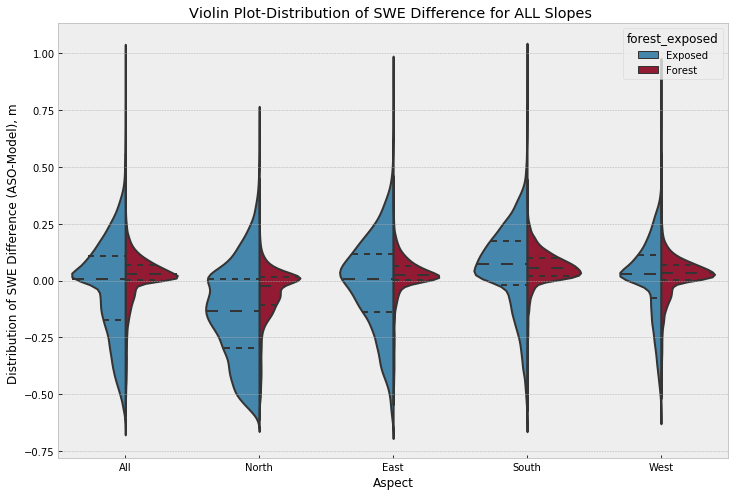

In [16]:
# Analyze SWE differences across ASPECTS
# Aspects and range of degrees
north1 = [0, 45] 
north2 = [315, 360]
east = [45, 135]
south = [135, 225]
west = [225, 315]
aspects = [north1, north2, east, south, west]
aspects_string = ['N1', 'N2', 'East', 'South', 'West']

# Input parameters for masks of different aspects
swe_map_loop=diff
dem_map_loop=dem_map
slope_map_loop=slope_map
aspect_map_loop=aspect_map
veg_map_loop=veg_map
swe_range_loop=[-5, 5]
dem_range_loop=[2500,4000]
slope_range_loop=[0, 90]

j=0
mask_df=mask0_df
for i in aspects:
    mask_forest_loop = _create_mask(swe_map_loop, dem_map_loop, slope_map_loop, aspect_map_loop,veg_map_loop,swe_range_loop, dem_range_loop, slope_range_loop, i, 1)
    mask_no_forest_loop = _create_mask(swe_map_loop, dem_map_loop, slope_map_loop, aspect_map_loop,veg_map_loop,swe_range_loop, dem_range_loop, slope_range_loop, i, 0)
    m_f_loop = ma.masked_where(mask_forest_loop == 0, swe_map_loop)
    m_nf_loop = ma.masked_where(mask_no_forest_loop == 0, swe_map_loop)
    m_ff_loop = array_resh_pd(m_f_loop)
    m_nff_loop = array_resh_pd(m_nf_loop)
    forest_delta_loop=m_ff_loop[0][np.where(~np.isnan(m_ff_loop))[0]]
    exposed_delta_loop=m_nff_loop[0][np.where(~np.isnan(m_nff_loop))[0]]
    forest_df_loop=pd.DataFrame(data={aspects_string[j]:forest_delta_loop.values}, index=forest_delta_loop.index)
    exposed_df_loop=pd.DataFrame(data={aspects_string[j]:exposed_delta_loop.values}, index=exposed_delta_loop.index)
    j=j+1;
    mask_df_loop=pd.concat([forest_df_loop, exposed_df_loop], axis=0)
    mask_df_loop=mask_df_loop.reindex(index=default_index);
    mask_df = pd.concat([mask_df, mask_df_loop],  axis = 1)
    mask_df.sort_index(inplace=True)

# Adjust for the split north aspect    
mask_df['North']=mask_df.N1.fillna(0) + mask_df.N2.fillna(0)
mask_df['North'][np.where(mask_df['North']==0.0)[0]]=np.nan
mask_df['North']
mask_df = mask_df.drop('N1', axis = 1)
mask_df = mask_df.drop('N2', axis = 1)

# Make violin plot
df=pd.melt(mask_df, value_vars=['All','North','East','South','West'],
           id_vars='forest_exposed')
plt.figure(figsize = (12,8))
sns.violinplot(x='variable', y='value', hue='forest_exposed', data=df, 
               scale='count',
               inner="quartile",  
               split=True)
plt.title('Violin Plot-Distribution of SWE Difference for ALL Slopes ')
plt.ylabel ('Distribution of SWE Difference (ASO-Model), m ')
plt.xlabel ('Aspect')

C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


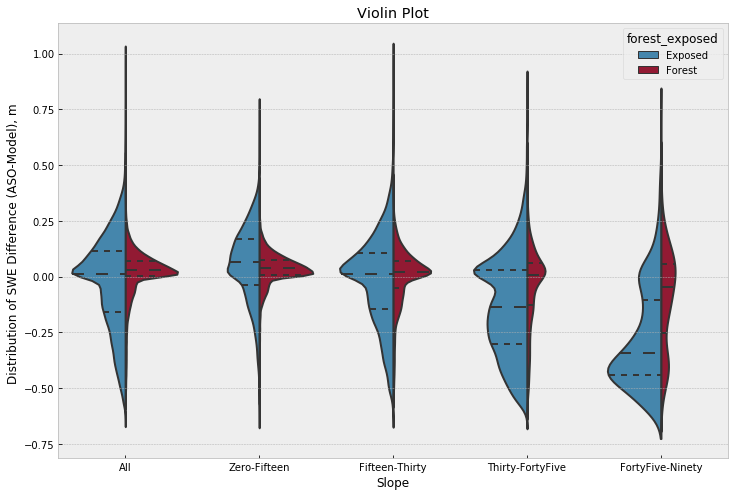

In [17]:
# Analyze SWE differences across SLOPES
# Slopes and range of degrees
all_slopes = [0, 90] 
zero_fifteen = [0,15]
fifteen_thirty = [15, 30]
thirty_fortyfive = [30, 45]
fortyfive_ninety = [45, 90]

slopes = [all_slopes, zero_fifteen, fifteen_thirty, thirty_fortyfive, fortyfive_ninety]
aspects_string = ['All', 'Zero-Fifteen', 'Fifteen-Thirty', 'Thirty-FortyFive', 'FortyFive-Ninety']

# Input parameters for masks of different slopes
swe_map_loop=diff
dem_map_loop=dem_map
slope_map_loop=slope_map
aspect_map_loop=aspect_map
veg_map_loop=veg_map
swe_range_loop=[-5, 5]
dem_range_loop=[2500,4000]
aspect_range_loop=[-1,360]

j=0
mask_df=mask0_df
for i in slopes:
    mask_forest_loop = _create_mask(swe_map_loop, dem_map_loop, slope_map_loop, aspect_map_loop,veg_map_loop,swe_range_loop, dem_range_loop, i, aspect_range_loop, 1)
    mask_no_forest_loop = _create_mask(swe_map_loop, dem_map_loop, slope_map_loop, aspect_map_loop,veg_map_loop,swe_range_loop, dem_range_loop, i, aspect_range_loop, 0)
    m_f_loop = ma.masked_where(mask_forest_loop == 0, swe_map_loop)
    m_nf_loop = ma.masked_where(mask_no_forest_loop == 0, swe_map_loop)
    m_ff_loop = array_resh_pd(m_f_loop)
    m_nff_loop = array_resh_pd(m_nf_loop)
    forest_delta_loop=m_ff_loop[0][np.where(~np.isnan(m_ff_loop))[0]]
    exposed_delta_loop=m_nff_loop[0][np.where(~np.isnan(m_nff_loop))[0]]
    forest_df_loop=pd.DataFrame(data={aspects_string[j]:forest_delta_loop.values}, index=forest_delta_loop.index)
    exposed_df_loop=pd.DataFrame(data={aspects_string[j]:exposed_delta_loop.values}, index=exposed_delta_loop.index)
    j=j+1;
    mask_df_loop=pd.concat([forest_df_loop, exposed_df_loop], axis=0)
    mask_df_loop=mask_df_loop.reindex(index=default_index);
    mask_df = pd.concat([mask_df, mask_df_loop],  axis = 1)
    mask_df.sort_index(inplace=True)

df=pd.melt(mask_df, value_vars=['All', 'Zero-Fifteen', 'Fifteen-Thirty', 'Thirty-FortyFive', 'FortyFive-Ninety'],
       id_vars='forest_exposed')
plt.figure(figsize = (12,8))
sns.violinplot(x='variable', y='value', hue='forest_exposed', data=df, 
               scale='count',
               inner="quartile",  
               split=True)
plt.title('Violin Plot')
plt.ylabel ('Distribution of SWE Difference (ASO-Model), m ')
plt.xlabel ('Slope')

C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Claire\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


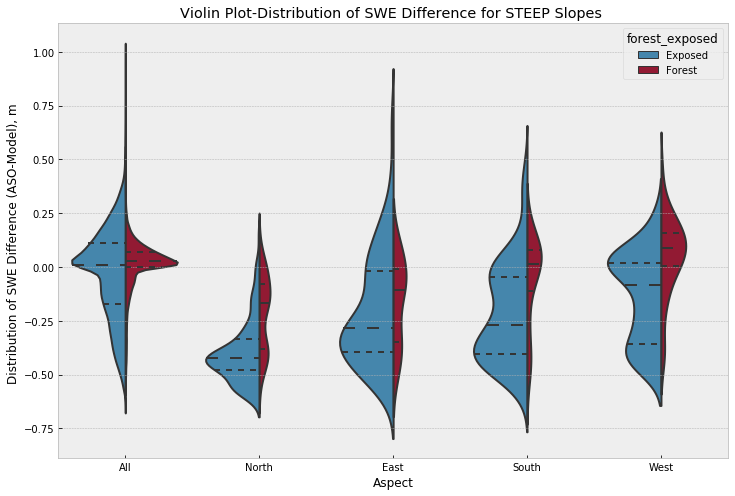

In [18]:
# Analyze SWE differences across ASPECTS, on STEEP SLOPES
# Aspects and range of degrees
north1 = [0, 45] 
north2 = [315, 360]
east = [45, 135]
south = [135, 225]
west = [225, 315]
aspects = [north1, north2, east, south, west]
aspects_string = ['N1', 'N2', 'East', 'South', 'West']

# Input parameters for masks of different aspects
swe_map_loop=diff
dem_map_loop=dem_map
slope_map_loop=slope_map
aspect_map_loop=aspect_map
veg_map_loop=veg_map
swe_range_loop=[-5, 5]
dem_range_loop=[2500,4000]
slope_range_loop=[45, 90] # NOTE that this is the high slopes range!

j=0
mask_df=mask0_df
for i in aspects:
    mask_forest_loop = _create_mask(swe_map_loop, dem_map_loop, slope_map_loop, aspect_map_loop,veg_map_loop,swe_range_loop, dem_range_loop, slope_range_loop, i, 1)
    mask_no_forest_loop = _create_mask(swe_map_loop, dem_map_loop, slope_map_loop, aspect_map_loop,veg_map_loop,swe_range_loop, dem_range_loop, slope_range_loop, i, 0)
    m_f_loop = ma.masked_where(mask_forest_loop == 0, swe_map_loop)
    m_nf_loop = ma.masked_where(mask_no_forest_loop == 0, swe_map_loop)
    m_ff_loop = array_resh_pd(m_f_loop)
    m_nff_loop = array_resh_pd(m_nf_loop)
    forest_delta_loop=m_ff_loop[0][np.where(~np.isnan(m_ff_loop))[0]]
    exposed_delta_loop=m_nff_loop[0][np.where(~np.isnan(m_nff_loop))[0]]
    forest_df_loop=pd.DataFrame(data={aspects_string[j]:forest_delta_loop.values}, index=forest_delta_loop.index)
    exposed_df_loop=pd.DataFrame(data={aspects_string[j]:exposed_delta_loop.values}, index=exposed_delta_loop.index)
    j=j+1;
    mask_df_loop=pd.concat([forest_df_loop, exposed_df_loop], axis=0)
    mask_df_loop=mask_df_loop.reindex(index=default_index);
    mask_df = pd.concat([mask_df, mask_df_loop],  axis = 1)
    mask_df.sort_index(inplace=True)

# Adjust for the split north aspect    
mask_df['North']=mask_df.N1.fillna(0) + mask_df.N2.fillna(0)
mask_df['North'][np.where(mask_df['North']==0.0)[0]]=np.nan
mask_df['North']
mask_df = mask_df.drop('N1', axis = 1)
mask_df = mask_df.drop('N2', axis = 1)

# Make violin plot
df=pd.melt(mask_df, value_vars=['All','North','East','South','West'],
           id_vars='forest_exposed')
plt.figure(figsize = (12,8))
sns.violinplot(x='variable', y='value', hue='forest_exposed', data=df, 
               scale='count',
               inner="quartile",  
               split=True)
plt.title('Violin Plot-Distribution of SWE Difference for STEEP Slopes ')
plt.ylabel ('Distribution of SWE Difference (ASO-Model), m ')
plt.xlabel ('Aspect')